# SoftMax Regression

## Image Classification Dataset

link : https://pytorch.org/vision/stable/datasets.html

In [ ]:
! pip install d2l

In [17]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
import matplotlib.pyplot as plt

d2l.use_svg_display()

pytorch **Street View House Numbers** Data set

link :http://ufldl.stanford.edu/housenumbers/



In [106]:
trans = transforms.ToTensor() # image 를 PIL type으로 바꿔준다.

train = torchvision.datasets.SVHN(root = "../data" , split = "train", 
                                          transform = trans, download = True)
test = torchvision.datasets.SVHN(root = "../data" , split = "test", 
                                          transform = trans, download = True)


Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


MNIST dataset

RGB 있는 한차원 높은 데이터로 시도

코드를 바꿔가면서 했지만 학습이 안된다...

가중치 계산 결과 nan값으로 미분이 안되는 것 같다.

In [230]:
trans = transforms.ToTensor()
train = torchvision.datasets.MNIST(
    root="../data", train=True, transform=trans, download=True)
test = torchvision.datasets.MNIST(
    root="../data", train=False, transform=trans, download=True)

In [194]:
len(train), len(test)

(60000, 10000)

In [102]:
train[1]

(tensor([[[0.3294, 0.3373, 0.3020,  ..., 0.3529, 0.3451, 0.3451],
          [0.3333, 0.3255, 0.2902,  ..., 0.3490, 0.3451, 0.3451],
          [0.3255, 0.3059, 0.2392,  ..., 0.3529, 0.3451, 0.3333],
          ...,
          [0.3922, 0.3843, 0.3725,  ..., 0.4078, 0.4000, 0.3922],
          [0.4039, 0.4157, 0.4039,  ..., 0.4039, 0.4039, 0.4118],
          [0.4039, 0.4039, 0.4078,  ..., 0.4431, 0.4078, 0.4039]],
 
         [[0.2980, 0.2863, 0.3059,  ..., 0.3059, 0.3020, 0.3059],
          [0.3020, 0.2863, 0.2706,  ..., 0.3216, 0.3098, 0.3176],
          [0.2980, 0.3020, 0.1961,  ..., 0.3333, 0.3255, 0.3216],
          ...,
          [0.3843, 0.3686, 0.3647,  ..., 0.4078, 0.4000, 0.3961],
          [0.4078, 0.4078, 0.4039,  ..., 0.4078, 0.4039, 0.3882],
          [0.4157, 0.4118, 0.4157,  ..., 0.4039, 0.4078, 0.3843]],
 
         [[0.2314, 0.2588, 0.2196,  ..., 0.2706, 0.2627, 0.2588],
          [0.2392, 0.2510, 0.2314,  ..., 0.2510, 0.2745, 0.2627],
          [0.2353, 0.2275, 0.2118,  ...,

feature들과 label을 포함

In [195]:
X,y = next(iter(data.DataLoader(train, batch_size = 18)))

In [196]:
X.shape

torch.Size([18, 1, 28, 28])

굳이 text label 만들 필요없다.

숫자 classification이다

In [73]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<AxesSubplot:title={'center':'5'}>,
       <AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'9'}>,
       <AxesSubplot:title={'center':'2'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'3'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'3'}>,
       <AxesSubplot:title={'center':'5'}>,
       <AxesSubplot:title={'center':'3'}>,
       <AxesSubplot:title={'center':'6'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'7'}>,
       <AxesSubplot:title={'center':'2'}>,
       <AxesSubplot:title={'center':'8'}>], dtype=object)

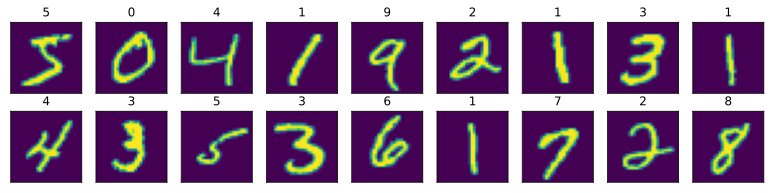

In [198]:

X,y = next(iter(data.DataLoader(train, batch_size = 18)))
# X = X.sum(1)/3
show_images(X.reshape(18,28,28), 2, 9, titles = [int(i) for i in y])

## Calling batches

In [75]:
def get_dataloader_workers(): ## 병렬 processing to read the data
  return 4

checking time of batch calling

In [199]:
batch_size = 300
train_iter = data.DataLoader(train, batch_size, shuffle = True,
                            num_workers = get_dataloader_workers())

timer = d2l.Timer()

for X, y in train_iter:
  continue

print(f'{timer.stop():.2f} sec')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


6.10 sec


batch load for SVHN Datasset

In [150]:
def load_data(batch_size, resize = None):

  trans = [transforms.ToTensor()]
  if resize:
        trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  train = torchvision.datasets.SVHN(root = "../data" , split = "train", 
                                          transform = trans, download = True)
  test = torchvision.datasets.SVHN(root = "../data" , split = "test", 
                                          transform = trans, download = True)
  
  return (data.DataLoader(train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

batch load for MNIST dataset

In [201]:
def load_data(batch_size, resize = None):

  trans = [transforms.ToTensor()]
  if resize:
        trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
 
  #MNIST dataset
  train = torchvision.datasets.MNIST(
    root="../data", train=True, transform=trans, download=True)
  test = torchvision.datasets.MNIST(
    root="../data", train=False, transform=trans, download=True)
  
  return (data.DataLoader(train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [202]:
train_iter, test_iter = load_data(18, resize = 64) # batch size = 18

for X, y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([18, 1, 64, 64]) torch.float32 torch.Size([18]) torch.int64


##Softmax Regression from Scratch

In [203]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 300
train_iter, test_iter = load_data(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [204]:
for X, y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([300, 1, 28, 28]) torch.float32 torch.Size([300]) torch.int64


###initializing parameters


after gray transformation

feature flatten vector : 28X 28 = 784

X = 300X784

weight = 784X 10(classes)

bias = (1x10)

In [220]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0,0.01, size = (num_inputs, num_outputs), requires_grad = True)

b = torch.zeros(num_outputs, requires_grad = True)

In [206]:
W.shape

torch.Size([784, 10])

###Modeling

In [207]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1,keepdim = True)

  return X_exp / partition

In [208]:
def net(X):
  return softmax(torch.matmul(X.reshape(-1,W.shape[0]), W)+b)

In [209]:
#loss

def cross_entropy(y_hat, y):
  return -torch.log(y_hat[range(len(y_hat)),y])
  #여기서 y_hat은 확률값(softmax 결과값)
  #정답에 해당하는 -log값
  #이후 다 더할 것임

In [210]:
def accuracy(y_hat, y):

  if len(y_hat.shape) > 1 and y_hat.shape[1] >1: #2차원에 각 label에 대한 확률 값이 있음을 확신
    y_hat = y_hat.argmax(axis = 1) #제일 높은 값의 index

  cmp = y_hat.type(y.dtype) == y # compare class : dtype akwcnaustj
  return float(cmp.type(y.dtype).sum()) #맞는 개수 세기

In [211]:
class Accumulator: 
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [212]:
def evaluate_accuracy(net, data_iter):

  if isinstance(net, torch.nn.Module):
    net.eval() # setting model to evaluation mode
  
  metric = Accumulator(2) 
  #two variables
  # number of correct predictions / number of predictions
  #accumulate sums over multiple variables

  with torch.no_grad():
    for X, y  in data_iter:
      
      metric.add(accuracy(net(X), y), y.numel())

  return metric[0] / metric[1] #최종 accuracy 평균값을 반환

###Training

In [213]:
def train_epoch_ch3(net, train_iter, loss, updater):

  if isinstance(net, torch.nn.Module):
    net.train() # set train mode

  #sum of training loss / sum of trainig accruacy // number of examples
  metric = Accumulator(3)

  for X, y in  train_iter:

    #Compute gradients and update parameter
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):

      #backpropagation
      updater.zero_grad() # batch 돌때마다 가중치 변화도 초기화
      l.mean().backward()
      updater.step()

    else: # using custom built optimizer and loss criterion
      l.sum().backward()
      updater(X.shape[0])
    
    metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    #return trainig loss and training accuracy

    return metric[0] / metric[2], metric[1] / metric[2]

In [214]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [218]:
def train_ch3(net, trian_iter, test_iter, loss, num_epochs, updater):

  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
  
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, trian_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch +1, train_metrics + (test_acc,))
  
  train_loss, train_acc= train_metrics

  #조건 반환 문
  # assert train_loss < 0.5, train_loss
  # assert train_acc <=1 and train_acc >0.7, train_acc
  # assert test_acc<=1 and test_acc>0.7, test_acc
  print(train_loss, train_acc)
  return

In [216]:
## updater 정의

lr = 0.2

def updater(batch_size):
  return d2l.sgd([W,b], lr, batch_size)

1.2454450480143229 0.7966666666666666


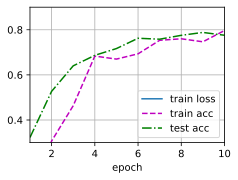

In [221]:

num_epochs = 10

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [222]:
W

tensor([[ 0.0047,  0.0184, -0.0029,  ...,  0.0187,  0.0003,  0.0010],
        [ 0.0093,  0.0038, -0.0051,  ..., -0.0126, -0.0143, -0.0045],
        [-0.0092,  0.0067, -0.0100,  ...,  0.0072, -0.0012, -0.0080],
        ...,
        [ 0.0107, -0.0010, -0.0123,  ...,  0.0016,  0.0120, -0.0065],
        [ 0.0163, -0.0008,  0.0088,  ..., -0.0288, -0.0029,  0.0006],
        [ 0.0028, -0.0029, -0.0100,  ...,  0.0160,  0.0050,  0.0097]],
       requires_grad=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


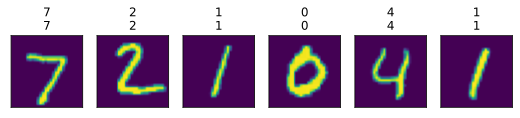

In [223]:
def predict_ch3(net, test_iter, n = 6):

    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = [int(i) for i in y]
    preds = [int(i) for i in net(X).argmax(axis=1)]
    titles = [str(true) +'\n' + str(pred) for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

##Using API

In [224]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 300
train_iter, test_iter = load_data(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


###Initialization

In [226]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784,10)) #flatten input layer + weight layer
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std = 0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

##Modeling

In [227]:
#loss
loss = nn.CrossEntropyLoss(reduction = "none")

In [228]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.1)

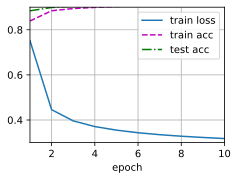

In [229]:
num_epochs = 10

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 다른 데이터로 시도

KMNIST - 잘 안된다 왤까...?

###Scratch

In [244]:
trans = transforms.ToTensor()
train = torchvision.datasets.KMNIST(
    root="../data", train = True, transform=trans,
    download=True)
test = torchvision.datasets.KMNIST(
    root="../data", train = False, transform=trans,
    download=True)

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ../data/KMNIST/raw/train-images-idx3-ubyte.gz to ../data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ../data/KMNIST/raw/train-labels-idx1-ubyte.gz to ../data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ../data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ../data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/KMNIST/raw



In [245]:
len(train), len(test)

(60000, 10000)

In [246]:
train[0][0].shape

torch.Size([1, 28, 28])

array([<AxesSubplot:title={'center':'8'}>,
       <AxesSubplot:title={'center':'7'}>,
       <AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'2'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'8'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'5'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'5'}>,
       <AxesSubplot:title={'center':'7'}>,
       <AxesSubplot:title={'center':'6'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'7'}>], dtype=object)

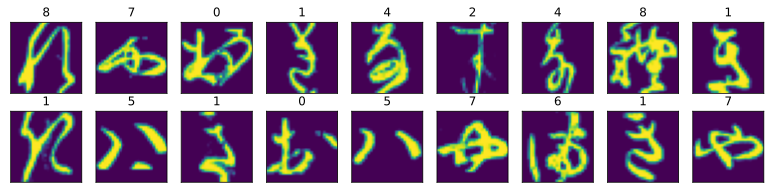

In [247]:
X,y = next(iter(data.DataLoader(train, batch_size = 18)))
show_images(X.reshape(18,28,28), 2, 9, titles = [int(i) for i in y])

In [264]:
def load_data(batch_size, resize = None):

  trans = [transforms.ToTensor()]
  if resize:
        trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
 
  #KMNIST dataset

  train = torchvision.datasets.KMNIST(
    root="../data", train = True, transform=trans,
    download=True)
  test = torchvision.datasets.KMNIST(
    root="../data", train = False, transform=trans,
    download=True)
  
  return (data.DataLoader(train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [265]:
batch_size = 300
train_iter, test_iter = load_data(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [257]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0,0.01, size = (num_inputs, num_outputs), requires_grad = True)

b = torch.zeros(num_outputs, requires_grad = True)

In [259]:
W.shape

torch.Size([784, 10])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored

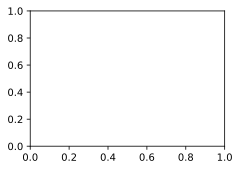

In [266]:
num_epochs = 10
lr = 0.2
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

###API

In [261]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784,10)) #flatten input layer + weight layer
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std = 0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

AssertionError: ignored

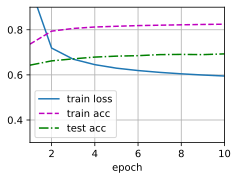

In [262]:
loss = nn.CrossEntropyLoss(reduction = "none")
trainer = torch.optim.SGD(net.parameters(), lr = 0.1)
num_epochs = 10

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)